## Face and Facial Keypoint detection

After we've trained a neural network to detect facial keypoints, wew can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, we'll first have to do some pre-processing.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

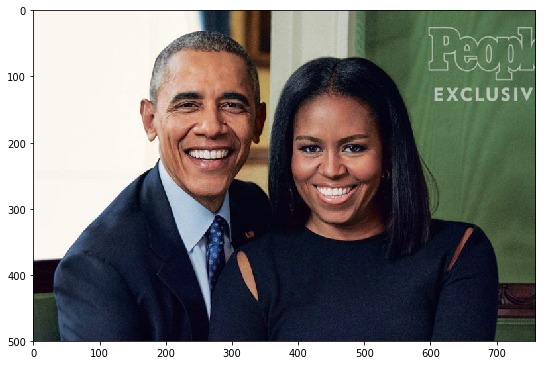

In [38]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
gray = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, we'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in we selected image.

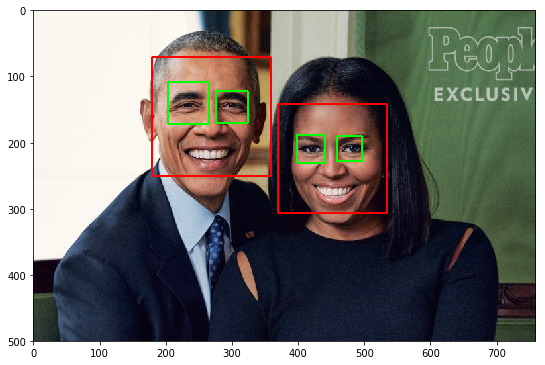

In [39]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# load in a haar cascade classifier for detecting eyes
eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 4)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # we may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,
                  (x,y),
                  (x+w,y+h),
                  (255,0,0),2) 
    
    # draw a rectangle around each detected eyes
    eye_gray = gray[y:y+h, x:x+w]
    eye_color = image_with_detections[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(eye_gray)
    
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(eye_color,
                      (ex,ey),
                      (ex+ew,ey+eh),
                      (0,255,0),2)
  
fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once we have an image to work with, the next step is to pre-process that image and feed it into our CNN facial keypoint detector.

First, load the best model by its filename.

In [40]:
import torch
from models import Net

net = Net()

## load the best saved model parameters 
net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

## print out your net and prepare it for testing 
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (drop3): Dropout(p=0.3)
  (drop4): Dropout(p=0.4)
  (drop5): Dropout(p=0.5)
  (drop6): Dropout(p=0.6)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, we'll transform those faces in Tensors that our CNN can accept as input images.

### Transform each detected face into an input Tensor

### Detect and display the predicted keypoints

In [72]:
def show_all_keypoints(image, keypoints):  
    batch_size = len(image)
    for i, face in enumerate(image):
        plt.figure(figsize=(8, 8))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the predicted key_pts data
        predicted_keypoints = keypoints[i].data
        predicted_keypoints = predicted_keypoints.numpy()
        # undo normalization of keypoints  
        predicted_keypoints = predicted_keypoints*50.0+100

        plt.imshow(face, cmap='gray')
        plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], s=20, marker='.', c='m')
        
        plt.axis('off')

    plt.show()

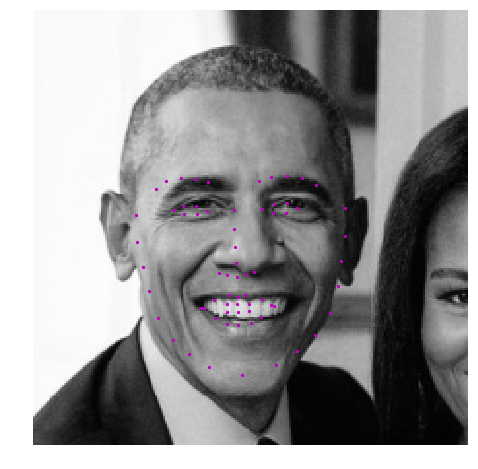

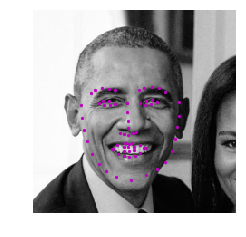

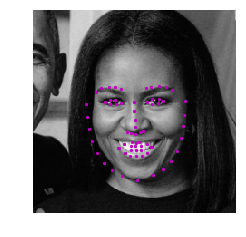

In [74]:
image_copy = np.copy(image)

images = [] 
keypoints = []
filling = 65


# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    #roi = image_copy[y:y+h, x:x+w]
    roi = image_copy[y-filling:y+h+filling, x-filling:x+w+filling]
    
    ## Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi / 255.0
    
    ## Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224,224))
    images.append(roi)
    
    ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = np.expand_dims(roi, axis=0)
    roi = np.expand_dims(roi, axis=0)
    
    input_img = torch.from_numpy(roi).type(torch.FloatTensor)
        
    ## Make facial keypoint predictions using your loaded, trained network
    
    output_pts = net.forward(input_img)
    
    output_pts = output_pts.view(output_pts.size()[0], 68, -1)
    keypoints.append(output_pts[0])

    ## Display each detected face and the corresponding keypoints        
        
    show_all_keypoints(images, keypoints)